# Test Nonhomogeneous Poisson

In [1]:
# std library
import os
import sys
import json
import random
from datetime import datetime

# third-party
import numpy as np
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import cmdstanpy
cmdstanpy.install_cmdstan()
from cmdstanpy import CmdStanModel

CmdStan install directory: /Users/zhuanglinsheng/.cmdstan
CmdStan version 2.36.0 already installed
Test model compilation


In [2]:
wd = os.getcwd()
current_dir = os.path.dirname(wd + '/')
parent_dir = os.path.dirname(current_dir)

# wd, current_dir, parent_dir
sys.path.append(parent_dir)

# import local modual
from poisson import simulate_nhpp

In [3]:
start_time = datetime(2025, 1, 1, 0, 0, 0)
end_time = datetime(2025, 4, 1, 0, 0, 0)

In [4]:
# Set parameter
intensity_effort_ratio = 1.5

In [5]:
# Generate data
rng_poisson = random.Random(42)
rng_uniform = random.Random(42)
## real-time (per hour) daily effort and intensity
ts_effort = np.load('./ts_effort.npy')
intensity = intensity_effort_ratio / 24 * ts_effort
print(intensity.size)
print('max (hour) intensity =', intensity.max())
## interpolate
intensity2 = np.append(intensity, [0])
flt_times = np.array(range(len(intensity2))) / len(intensity)
fn_intensity = interp1d(flt_times, intensity2)
## generate events
events = simulate_nhpp(start_time, end_time, fn_intensity, 1, rng_poisson, rng_uniform)
print('number of events =', len(events))

2160
max (hour) intensity = 1.001183527469498
number of events = 48


In [6]:
# Save to json file
test_nhpp_data = os.path.join(wd, 'test_nhpp_data.json')
with open(test_nhpp_data, 'w') as f:
	json.dump({
		'hours': int((end_time - start_time).total_seconds() / 3600),
		'effort': ts_effort.tolist(),
		'N': len(events),
		'events': [(t - start_time).total_seconds() / 3600 for t in events],
	}, f, indent=4)

In [7]:
# Build model
stan_file_nhpp = os.path.join(wd, 'test_nhpp.stan')
stan_model_nhpp = CmdStanModel(stan_file=stan_file_nhpp)

In [8]:
# Fit data
fit_nhpp = stan_model_nhpp.sample(
	data=test_nhpp_data,
	chains=4,
	iter_warmup=2000,
	iter_sampling=4000,
	parallel_chains=4,
	show_console=False,
)

18:31:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:31:51 - cmdstanpy - INFO - CmdStan done processing.


In [9]:
posteriors = fit_nhpp.summary()
posteriors.iloc[:2]

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-152.98500,0.008428,0.705933,0.308381,-154.42200,-152.71100,-152.48700,7577.80,9395.31,1.00065
r,1.53162,0.002795,0.218429,0.216007,1.18913,1.52125,1.91057,6091.07,8193.44,1.00071


Compare:
- intensity_effort_ratio = 1.5

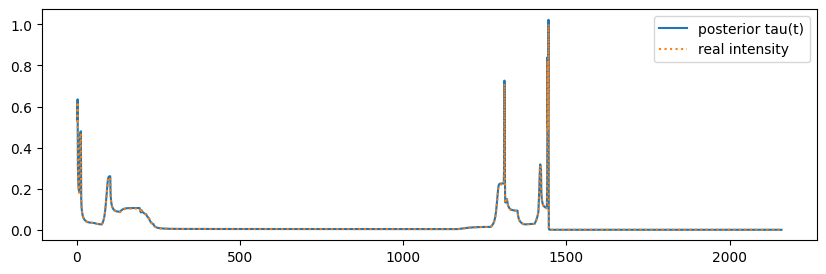

In [10]:
# compare posteriors intensity with the real
posterior_intensity = posteriors['Mean'].iloc[2:2 + intensity.size]

plt.figure(figsize=(10, 3))
plt.plot(list(range(len(intensity))), posterior_intensity, label='posterior tau(t)')
plt.plot(list(range(len(intensity))), intensity, label='real intensity', linestyle='dotted')
plt.legend()
plt.show()